In [1]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

/anaconda3/envs/azmlenv/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)
/anaconda3/envs/azmlenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-local-regression'
project_folder = './sample_projects/automl-local-regression'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Found the config file in: /Users/trinakarmakar/codelibs/aml_config/config.json


,
Experiment Name,automl-local-regression
Location,eastus2
Project Directory,./sample_projects/automl-local-regression
Resource Group,mymlexp
SDK version,0.1.74
Subscription ID,1e30ba0a-66fa-4479-9bca-95ba2cf71b20
Workspace Name,mymlworkspace


In [3]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

In [4]:
# Load the diabetes dataset, a well-known built-in small dataset that comes with scikit-learn.
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)

columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
automl_config = AutoMLConfig(task = 'regression',
                             max_time_sec = 600,
                             iterations = 10,
                             primary_metric = 'spearman_correlation',
                             n_cross_validations = 5,
                             debug_log = 'automl.log',
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

In [6]:
local_run = experiment.submit(automl_config, show_output = True)

Parent Run ID: AutoML_95c40106-d015-4da4-94b2-2b86ef222b62
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      MaxAbsScaler ExtraTreesRegressor      0:00:07.265565           0.698     0.698
         1      StandardScalerWrapper RandomForestRegr0:00:05.403351           0.689     0.698
         2      StandardScalerWrapper KNeighborsRegres0:00:04.883624           0.701     0.701
         3      StandardScalerWrapper GradientBoosting0:00:06.420273           0.701     0.701
         4      

In [7]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-local-regression,AutoML_95c40106-d015-4da4-94b2-2b86ef222b62,automl,Completed,Link to Azure Portal,Link to Documentation


In [8]:
from azureml.train.widgets import RunDetails
RunDetails(local_run).show()

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

In [9]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
explained_variance,0.495558,0.489559,0.460291,0.509891,0.476664,0.491541,0.490480,0.458824,0.406171,0.518125
mean_absolute_error,47.160483,46.043692,48.623435,44.638841,46.282905,46.316555,44.982650,49.167708,51.655219,44.968775
median_absolute_error,44.183299,41.500806,45.722450,40.872725,42.001903,40.924479,40.293991,44.480263,49.540164,40.217908
normalized_mean_absolute_error,0.146917,0.143438,0.151475,0.139062,0.144184,0.144288,0.140133,0.153170,0.160920,0.140090
normalized_median_absolute_error,0.137643,0.129286,0.142438,0.127329,0.130847,0.127491,0.125526,0.138568,0.154331,0.125289
normalized_root_mean_squared_error,0.174512,0.175745,0.180329,0.172797,0.178581,0.174449,0.174868,0.181117,0.188517,0.170289
normalized_root_mean_squared_log_error,0.169105,0.167951,0.169446,0.166342,0.170832,0.165206,0.166680,0.177280,0.180548,0.163450
r2_score,0.474075,0.465272,0.440167,0.486158,0.450926,0.474400,0.472716,0.434574,0.390026,0.499636
root_mean_squared_error,56.018487,56.414209,57.885652,55.467991,57.324374,55.998023,56.132474,58.138573,60.513928,54.662827
root_mean_squared_log_error,0.438189,0.435200,0.439072,0.431029,0.442665,0.428087,0.431905,0.459374,0.467842,0.423537


In [10]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-regression,
Id: AutoML_95c40106-d015-4da4-94b2-2b86ef222b62_9,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x1a21fc5908>), ('ExtraTreesRegressor', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.6, max_leaf_nodes=None, min_impurity_decrease=0.0,
       ...timators=200, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))])


In [11]:
lookup_metric = "root_mean_squared_error"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-regression,
Id: AutoML_95c40106-d015-4da4-94b2-2b86ef222b62_9,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x10f496860>), ('ExtraTreesRegressor', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.6, max_leaf_nodes=None, min_impurity_decrease=0.0,
        ...timators=200, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))])


In [12]:
#show and run the model from 3rd iteration
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automl-local-regression,
Id: AutoML_95c40106-d015-4da4-94b2-2b86ef222b62_3,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x10f4ac080>), ('GradientBoostingRegressor', GradientBoostingRegressor(alpha=0.5, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
        ...       random_state=None, subsample=0.44999999999999996, verbose=0,
             warm_start=False))])


In [13]:
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

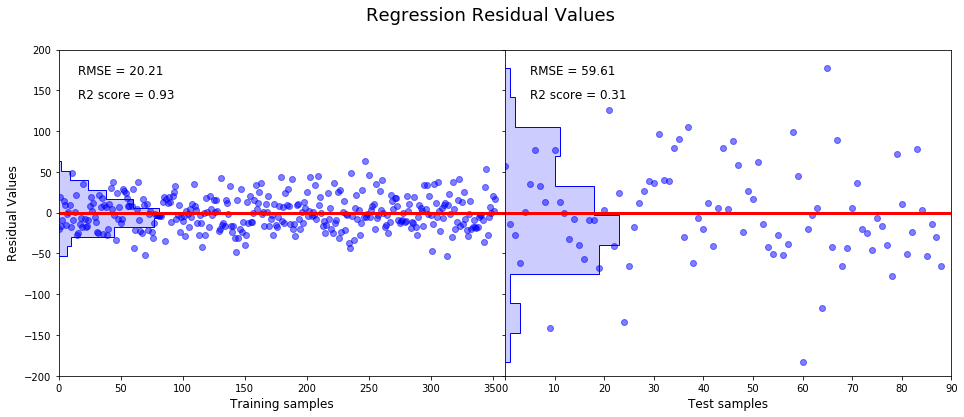

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step');
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10);

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

plt.show()